# Plot wet snow time series along with SNOTEL data

Last updated September 7, 2023

This notebook plots the wet snow time series of a site, and brings in some SNOTEL data for comparison.

In [1]:
!pip install -q deafrica-tools 
!pip install -q geopandas

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd
import geopandas as gpd
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime

import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters

from dask.distributed import Client


In [3]:
client = Client(local_directory='/tmp', processes=False)
client

/home/eric/miniconda3/envs/spicy_snow_env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45265 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.29.231.250:45265/status,
Dashboard: http://172.29.231.250:45265/status,Workers: 1
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: False
Comm: inproc://172.29.231.250/29300/1,Workers: 1
Dashboard: http://172.29.231.250:45265/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: inproc://172.29.231.250/29300/4,Total threads: 16
Dashboard: http://172.29.231.250:36701/status,Memory: 15.49 GiB
Nanny: None,


## Choose a site

In [4]:
files = sorted(glob('spicy_s1_stacks/*.nc'))


f = files[1]
start_year = 2019
start_year = 2020

ds_name = f.split('stacks/')[-1].split('.')[0]
print(datetime.now(), f' -- starting {ds_name}')

# Open dataset 
ds_ = xr.open_dataset(f).load()
dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
closest_ts_idx = np.where(td == td.min())[0][0]
closest_ts = dataset.time[closest_ts_idx]

a = 2.5
b = 0.2
c = 0.55

ds = retrieval_from_parameters(dataset,A=a,B=b,C=c,wet_SI_thresh=0,freezing_snow_thresh=1,wet_snow_thresh=-2)

2023-09-07 22:31:11.277344  -- starting Banner_2021-03-15


## Check out the wet snow time series

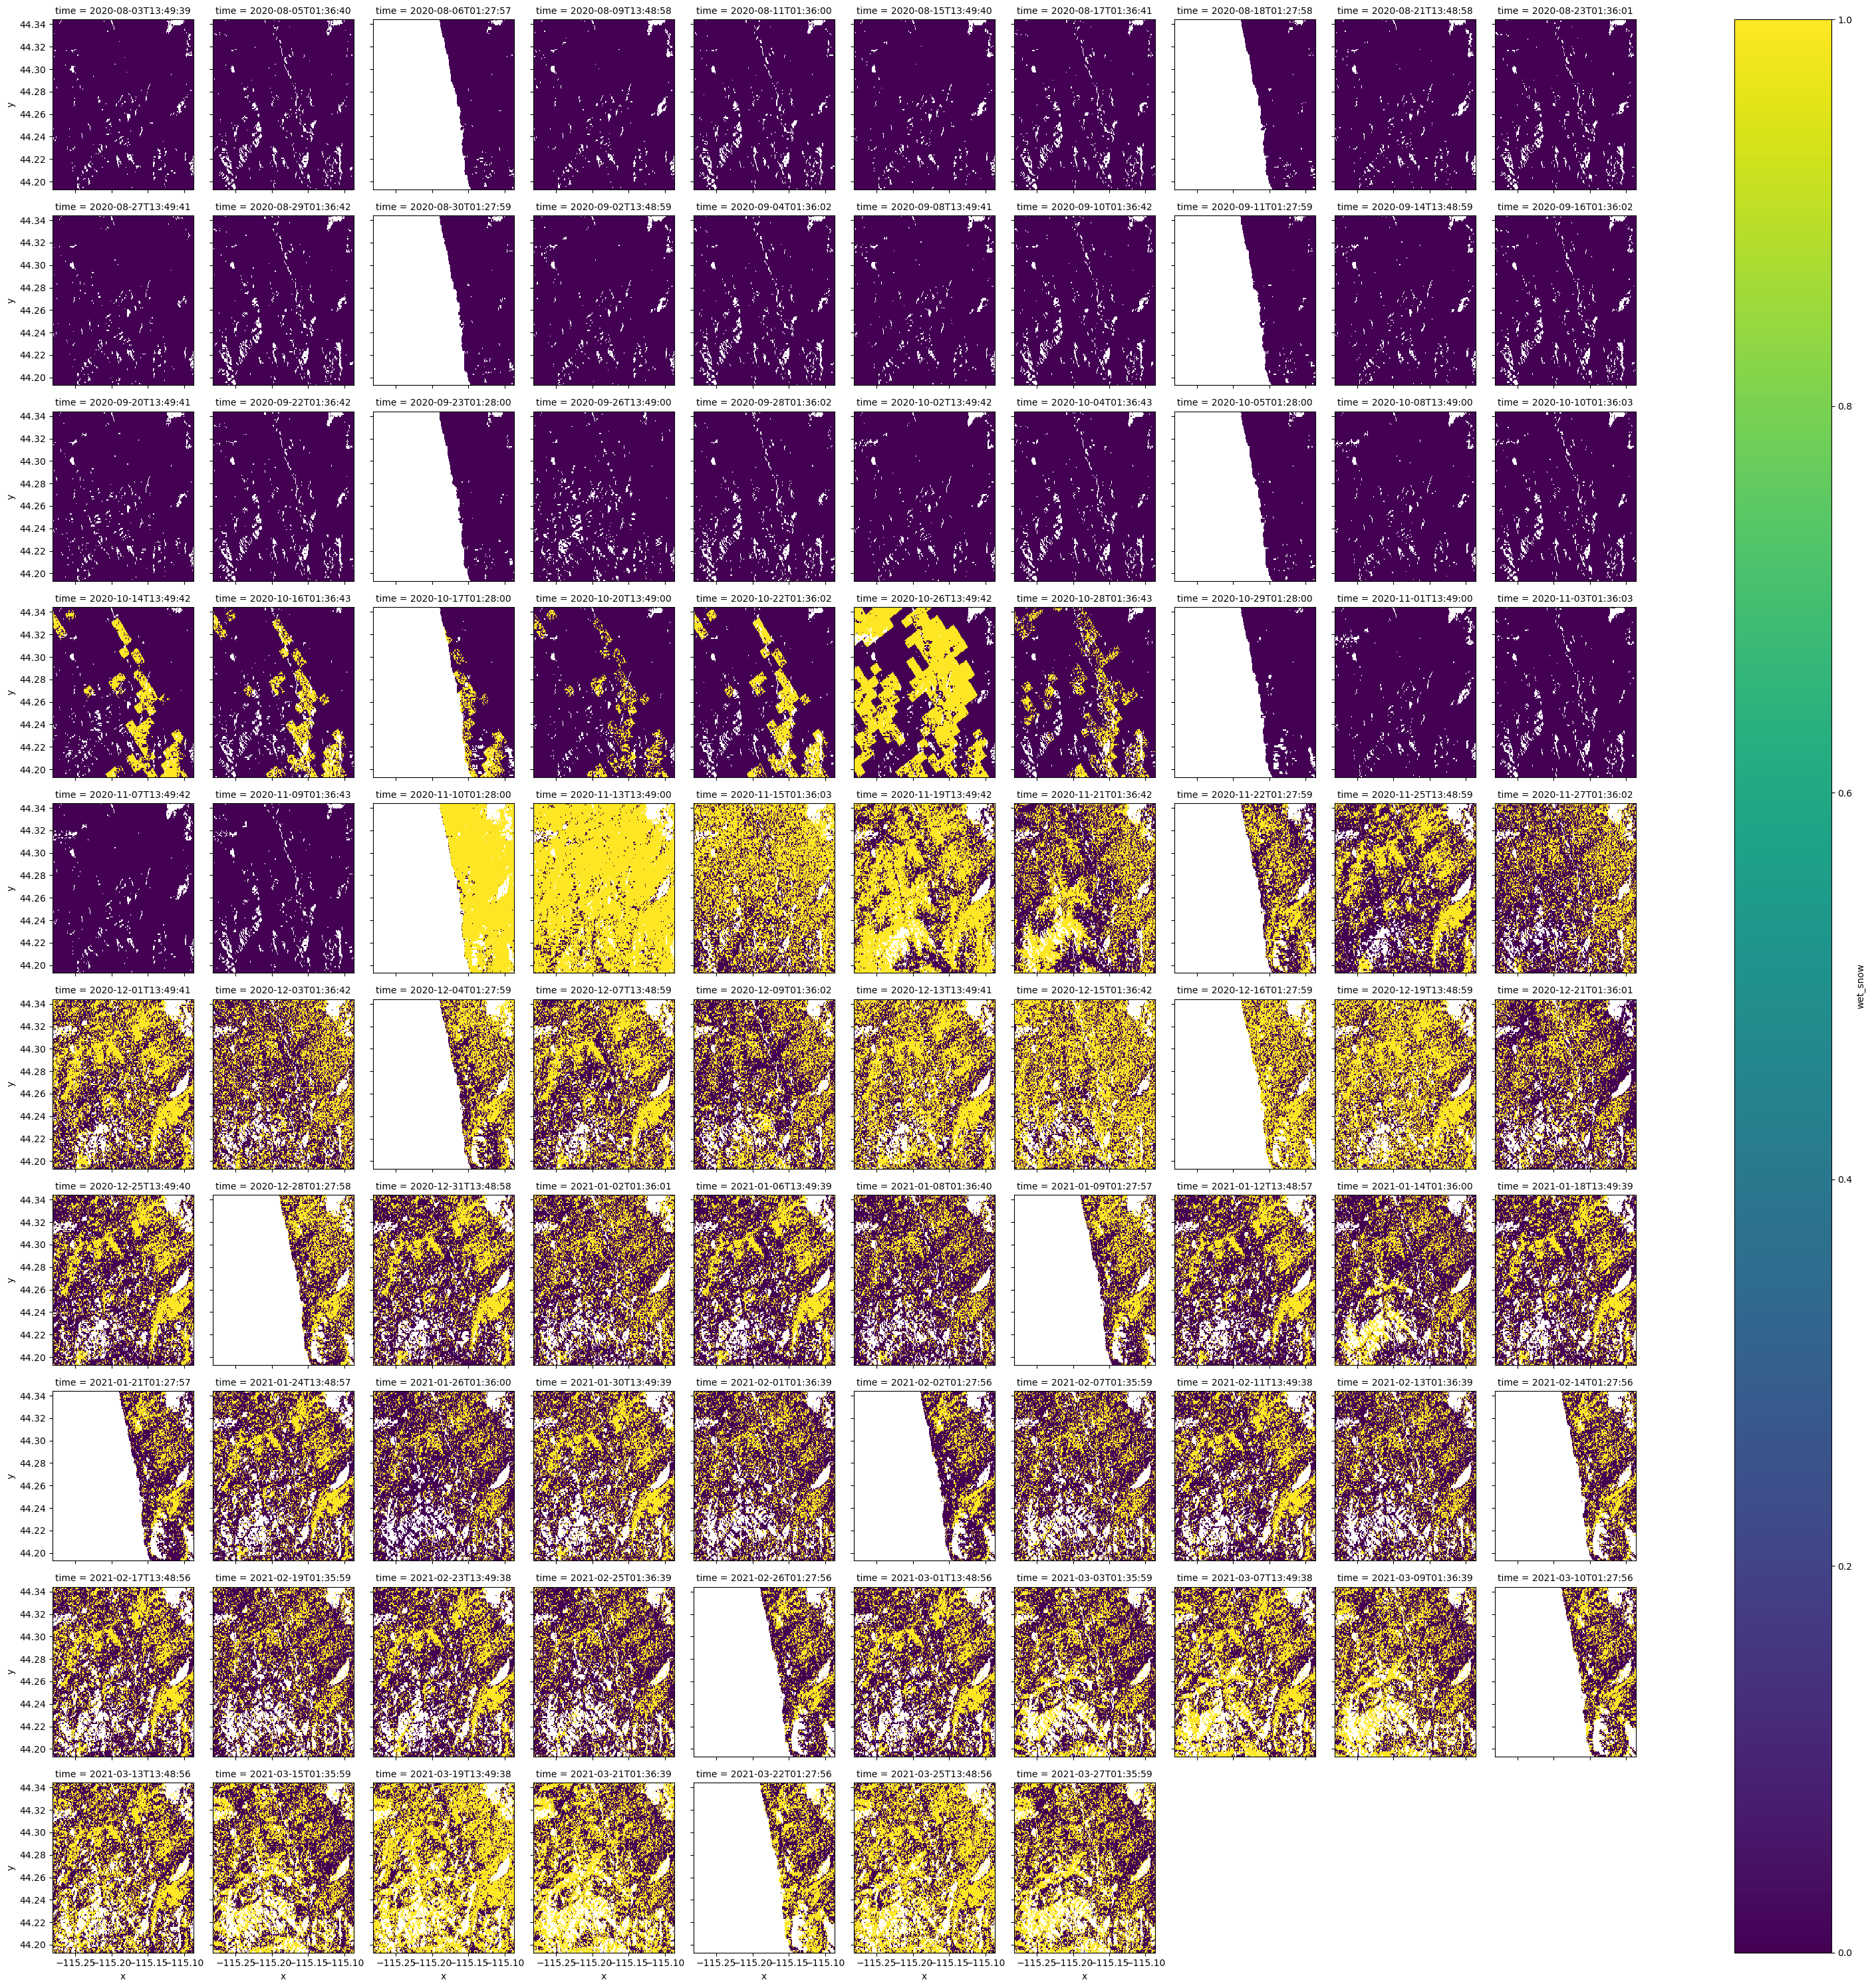

In [5]:
ds['wet_snow'].plot(col='time',col_wrap=10)
#ds['wet_flag'].plot(col='time',col_wrap=10)
#ds['alt_wet_flag'].plot(col='time',col_wrap=10)
#ds['freeze_flag'].plot(col='time',col_wrap=10)
#ds['perma_wet'].plot(col='time',col_wrap=10)
#ds['snow_index'].plot(col='time',col_wrap=10)


## Fill partial scenes and clip to lidar area

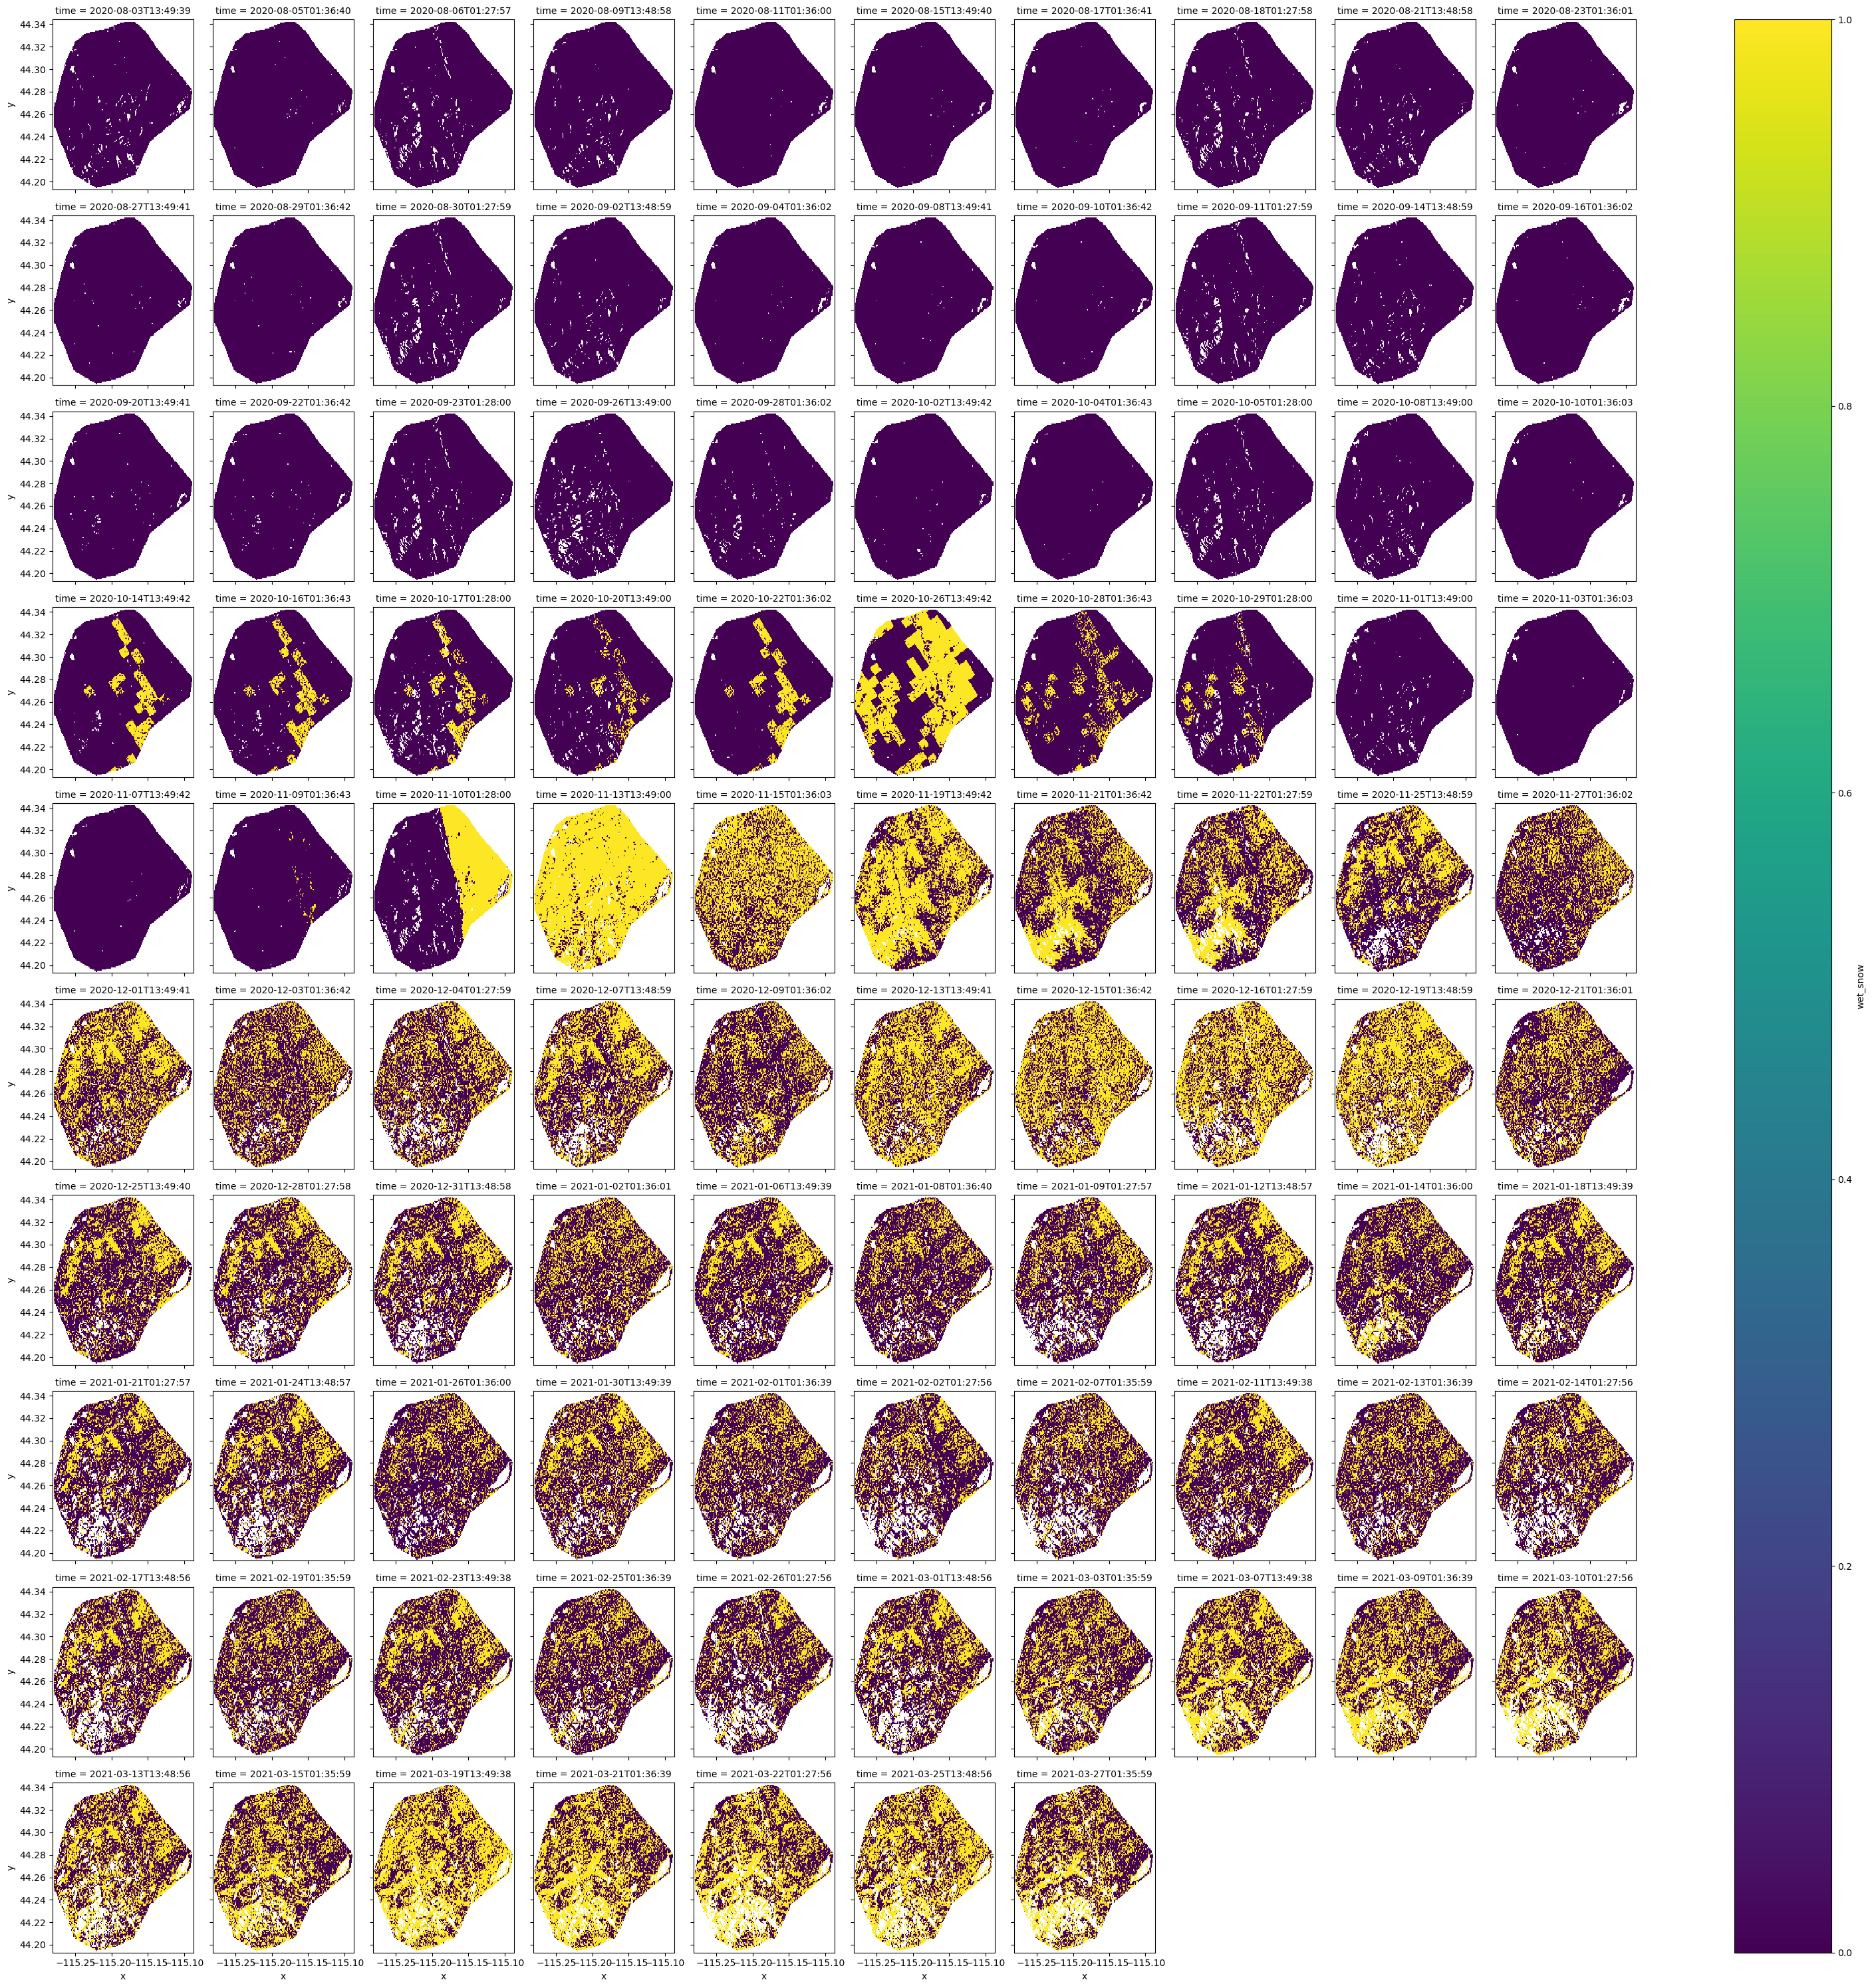

In [6]:
ds_interp = ds.interpolate_na(dim='time',method='nearest',limit=1).where(~ds['lidar-sd'].isnull())
ds_interp['wet_snow'].plot(col='time',col_wrap=10)

## Create snow map time series: 0 is no snow, 1 is wet snow, 2 is dry snow

In [7]:
all_snow = (ds_interp['ims']==4).astype(float)*2
wet_snow = ds_interp['wet_snow'].astype(float)
dry_snow = all_snow-wet_snow

ds_interp['snow_ts'] = all_snow - wet_snow 
ds_interp['snow_ts'] = ds_interp['snow_ts'].where(ds_interp['snow_ts']!=-1,0)

In [8]:
# get outline of lidar area
clipped_area = ds_interp['snow_ts'].isel(time=-1)
ds.rio.set_crs('EPSG:4326')
gdf = xr_vectorize(clipped_area,crs=ds.rio.crs,transform=ds.rio.transform(),mask=(clipped_area.values==1)|(clipped_area.values==2))
boundary_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf.unary_union).boundary)

## Resample to weekly

In [9]:
ds_resample = ds_interp['snow_ts'].sel(time=slice(f'{start_year}-10',f'{start_year+1}-04')).resample(time='7D').mean(dim='time')
ds_resample = ds_resample.round()

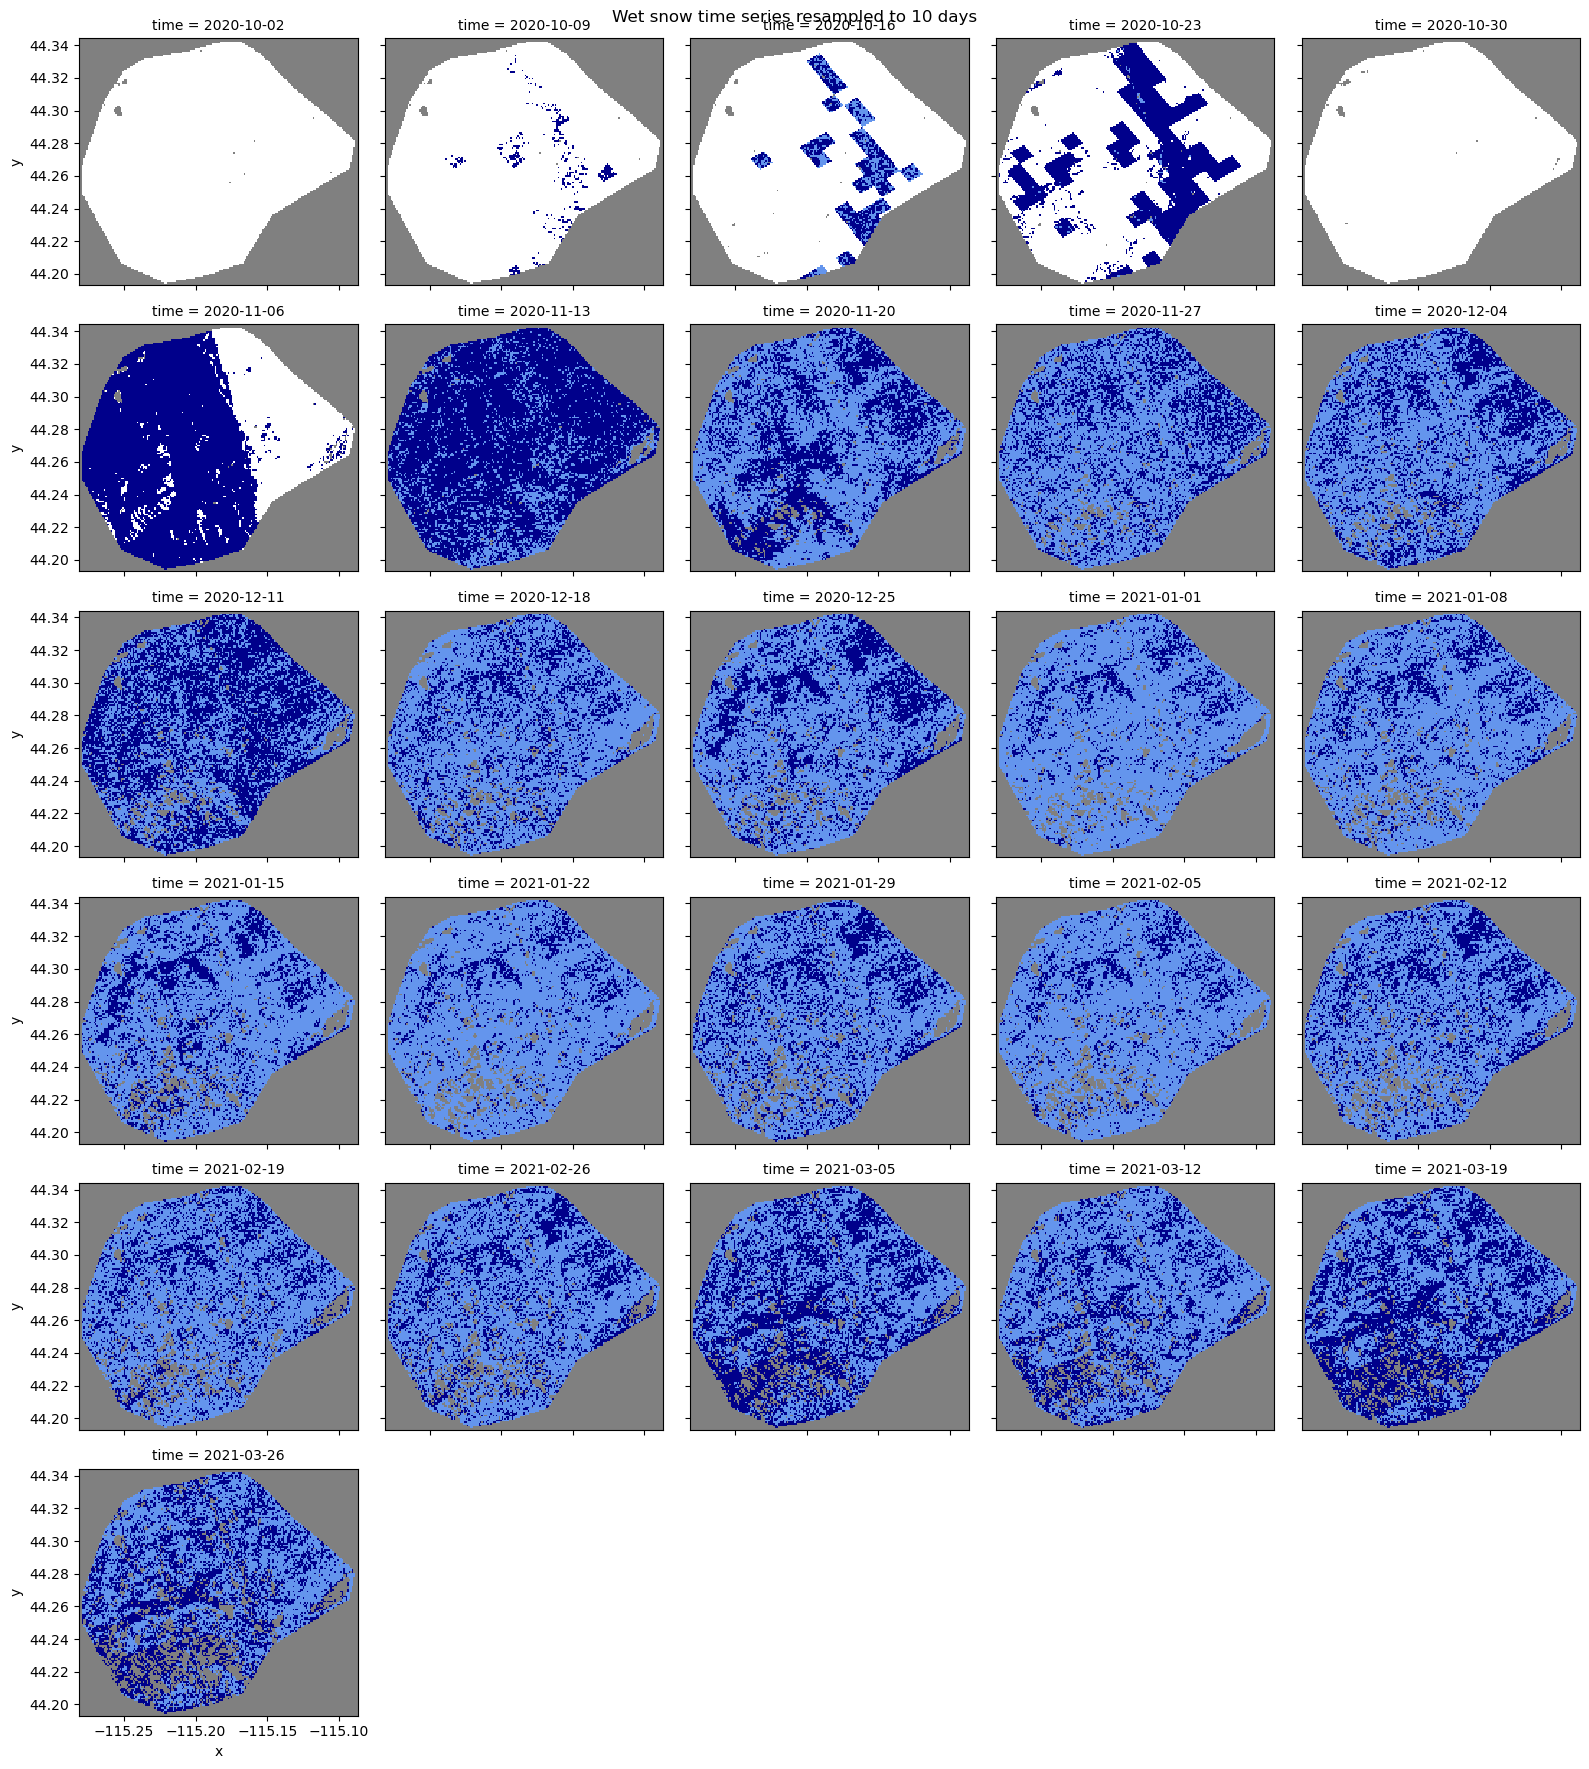

In [10]:
wet_cmap = ListedColormap(["white", "darkblue", "cornflowerblue"])
f = ds_resample.plot(col='time',col_wrap=5, add_colorbar=False,cmap=wet_cmap) # YlGnBu

for ax in f.axs.flatten():
    ax.set_facecolor('gray')
    #boundary_gdf.plot(ax=ax,color='black')
    #ax.plot(boundary_gdf,color='black')

f.fig.suptitle('Wet snow time series resampled to 10 days')
#f.fig.set_size_inches(11,7)

f.fig.tight_layout()
f.fig.savefig('figures/wet_snow_ts_10days.png',dpi=600)

## Bring in some SNOTEL data and compare with number of wet pixels over time

In [11]:
code = '312_ID_SNTL'
snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{code}.parquet')
snotel_TAVG = snotel_data['TAVG'].loc[slice(f'{start_year}-08',f'{start_year+1}-04')]

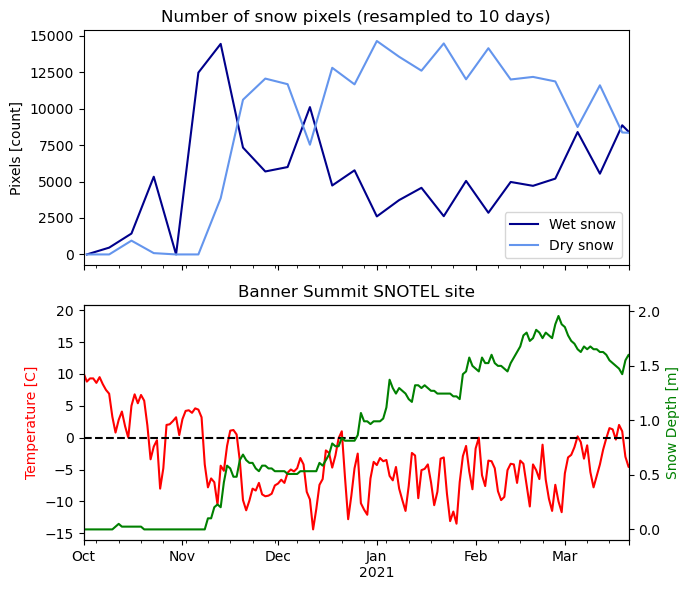

In [12]:
f,ax=plt.subplots(2,1,figsize=(7,6),sharex=True)
PRCP_ax = ax[1].twinx()

(ds_resample==1).sum(dim=['x','y']).plot(ax=ax[0],color='darkblue')
(ds_resample==2).sum(dim=['x','y']).plot(ax=ax[0],color='cornflowerblue')
ax[0].set_xlim([pd.to_datetime(f'{start_year}-10'),pd.to_datetime(f'{start_year+1}-03-21')])

snotel_TAVG.plot(ax=ax[1], color='red')

ax[1].axhline(0,color='black',linestyle='--')
snotel_data['SNWD'].loc[slice(f'{start_year}-08',f'{start_year+1}-04')].plot(ax=PRCP_ax,color='green')
ax[1].set_xlim([pd.to_datetime(f'{start_year}-10'),pd.to_datetime(f'{start_year+1}-03-21')])

ax[0].set_title('Number of snow pixels (resampled to 10 days)')
ax[0].set_ylabel('Pixels [count]')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].set_title('Banner Summit SNOTEL site')
ax[1].set_ylabel('Temperature [C]')
PRCP_ax.set_xlabel('')
PRCP_ax.set_ylabel('Snow Depth [m]')

ax[1].yaxis.label.set_color('red')
PRCP_ax.yaxis.label.set_color('green')

ax[0].legend(['Wet snow','Dry snow'])

plt.tight_layout()

f.savefig('figures/wet_snow_and_snotel.png',dpi=600)